In [1]:
import keras

Using Theano backend.
Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 5103)
/home/joakim/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
#path = "data/"
path = "data/work_data/sample/"
#path = "data/base_data/"
#model_path = "model/"
batch_size=16

In [9]:
import utils; reload(utils)
from utils import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division, print_function
from keras.layers import Input, Dense
from keras.models import Model
from keras.preprocessing import image
import os
from glob import glob
import numpy as np
import annotationHandler; reload(annotationHandler)
import bboxgenerator; reload(bboxgenerator)

<module 'bboxgenerator' from 'bboxgenerator.pyc'>

In [10]:
#This is a workaround for now to get bounding-boxes from the filename-structure of the keras-impl.
#we have to reassign the batches afterwards with boundingboxes provided.
train_path = path + 'train'
valid_path = path + 'valid'
size=(224,224)
batches = get_batches(train_path, batch_size=batch_size, shuffle=False, target_size=size)
val_batches = get_batches(valid_path, batch_size=batch_size, shuffle=False, target_size=size)
train_bboxes = annotationHandler.create_bbx("data/annotations", size, batches.filenames, train_path)
val_bboxes = annotationHandler.create_bbx("data/annotations", size, val_batches.filenames, valid_path)

Found 150 images belonging to 8 classes.
Found 34 images belonging to 8 classes.
Annotations for 3297 images found.
Creating blank bounding boxes for the rest.
Annotations for 3297 images found.
Creating blank bounding boxes for the rest.


In [12]:
size=(224,224)
batches = bboxgenerator.DirectoryIterator(directory=train_path, batch_size=batch_size, target_size=size, shuffle=True, mappable_extras=[train_bboxes])
val_batches = bboxgenerator.DirectoryIterator(valid_path, batch_size=batch_size, target_size=size, shuffle=False, mappable_extras=[val_bboxes])

Found 150 images belonging to 8 classes.
Found 34 images belonging to 8 classes.


In [14]:
test = next(batches)

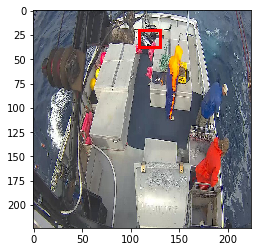

In [15]:
utils.show_bb(test, 2)

In [16]:
from vgg16bn import Vgg16BN
vgg = Vgg16BN(size,include_top=False)
model = vgg.model

for layer in model.layers:
    layer.trainable=False

vgg16_bn_conv.h5


In [17]:
p = 0.2
x = model.output
x = MaxPooling2D()(x)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

In [18]:
model = Model(input=model.input, output=[x_bb, x_class])
model.compile(Adam(lr=0.001), 
              loss=['mse', 'categorical_crossentropy'], 
              metrics=['accuracy'],
              loss_weights=[.001, 1.])

In [20]:
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=5, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/5
150/150 [==============================] - 3s - loss: 8.0011 - bb_loss: 5517.4050 - class_loss: 2.4837 - bb_acc: 0.2933 - class_acc: 0.3267 - val_loss: 9.8919 - val_bb_loss: 4969.6751 - val_class_loss: 4.9222 - val_bb_acc: 0.2941 - val_class_acc: 0.2941

In [15]:
model.save("model.keras")

## Submit

In [18]:
testData = get_data(path+"test", target_size=size)

Found 1000 images belonging to 1 classes.


In [23]:
preds = model.predict(testData, batch_size=batch_size*2)

In [34]:
filenames = testFiles
ids = np.array([f[4:] for f in filenames])
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
def do_clip(arr, mx): return np.clip(arr, (1-mx)/7, mx)
subm = do_clip(preds[1],0.82)


In [36]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', ids)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00358.jpg,0.505759,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.460276
1,img_07173.jpg,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.820000
2,img_07143.jpg,0.025714,0.025714,0.025714,0.025714,0.820000,0.025714,0.025714,0.025714
3,img_05015.jpg,0.306355,0.025714,0.025714,0.665839,0.025714,0.025714,0.025714,0.025714
4,img_03229.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.050406


In [38]:
submission.to_csv('fishy2.csv', index=False)